This notebook expands on the latent factor model to predict ratings for a user, anime pair by adding in an item feature -- the genre. There are 39 different genres which will be represented via one-hot encoding. An anime might fall into multiple genres, e.g. "historical" and "drama." 

Each feature (i.e. individaul genre) has associated with it a parameter vector of the same dimensionality as latent factors, and so the model learns to "offsets" the latent factors based on the presence of a given feature (i.e. genre).

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline
matplotlib.style.use('seaborn')

In [3]:
import pandas as pd

In [4]:
from animerec.data import get_data
users, anime = get_data()

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(users, test_size = 0.1) #let's split up the dataset into a train and test set.
train, valid = train_test_split(train, test_size = 0.2) #let's split up the dataset into a train and valid set.

In [6]:
from animerec.data import remove_users
train = remove_users(train, 10)

In [7]:
#define validation set
valid_users = valid['user_id']
valid_anime = valid['anime_id']
valid_ratings = valid['rating']

In [8]:
genres = anime.genre.apply(lambda x: str(x).split(","))
genres2 = genres.apply(pd.Series)
all_genres = []
for i in range(len(genres2.columns)):
    genres2[i] = genres2[i].str.strip()
    all_genres += map(lambda s: str(s).strip(), list(genres2[i].unique()))
all_genres = list(np.unique(all_genres))

In [9]:
genre_map = {}
for i, x in enumerate(all_genres): genre_map.update({x:i})
nGenres = len(all_genres)

In [10]:
indexed = anime.set_index('anime_id')
indexed.index.name = None
ind = indexed.ix[train.anime_id.get_values()]

In [11]:
train_genres = ind.genre.map(lambda x: [genre_map[j.strip()] for j in str(x).split(',')])

In [12]:
ohe_genres = np.zeros((len(train_genres), nGenres))
for i, row in enumerate(train_genres): ohe_genres[i, row] = 1


In [13]:
v_ind = indexed.ix[valid.anime_id.get_values()]
valid_genres = v_ind.genre.map(lambda x: [genre_map[j.strip()] for j in str(x).split(',')])

v_ohe_genres = np.zeros((len(valid_genres), nGenres))
for i, row in enumerate(valid_genres): v_ohe_genres[i, row] = 1



In [14]:
test_ind = indexed.ix[test.anime_id.get_values()]
test_genres = test_ind.genre.map(lambda x: [genre_map[j.strip()] for j in str(x).split(',')])

test_ohe_genres = np.zeros((len(test_genres), nGenres))
for i, row in enumerate(test_genres): test_ohe_genres[i, row] = 1




In [15]:
#initialize some local variables
nUsers = len(train.user_id.unique())
nAnime = len(train.anime_id.unique())

# we'll need some data structures in order to vectorize computations
from collections import defaultdict
user_ids = train.user_id
item_ids = train.anime_id

user_index = defaultdict(lambda: -1) # maps a user_id to the index in the bias term.
item_index = defaultdict(lambda: -1) # maps an anime_id to the index in the bias term.

counter = 0
for user in user_ids:
    if user_index[user] == -1:
        user_index[user] = counter
        counter += 1 

counter = 0
for item in item_ids:
    if item_index[item] == -1:
        item_index[item] = counter
        counter += 1 

In [16]:
#Terms needed for the latent factors.
k = 3; # hyper-parameter

In [17]:
import tensorflow as tf

In [18]:
y = tf.cast(tf.constant(train['rating'].as_matrix(), shape=[len(train),1]), tf.float32)

In [19]:
def objective(alpha, Bi, Bu, Gi, Gu, Pi, y, lam): #Gi, Gu = gamma_i, gamma_u = latent factors for items, users 
    
    '''
    Like in the linear model, we need to construct the "full" matrix for each (user, item) pair. However, with the
    addition of the latent factor terms, it will waste memory to hold each variable in its own tensor.
    Instead, create one intermediary tensor to represent our prediction ("pred") and simply incrementally add to that
    each additional variable.
    '''
    pred = tf.gather(Bi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix()) #Bi_full
    pred += tf.gather(Bu, train.user_id.map(lambda _id: user_index[_id]).as_matrix()) #Bu_full
    
    Gi_full = tf.gather(Gi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix()) #latent factors of items
    Gu_full = tf.gather(Gu, train.user_id.map(lambda _id: user_index[_id]).as_matrix()) #latent factors of users

    Pi_full = tf.matmul(tf.constant(ohe_genres, dtype=tf.float32), Pi) 
    
    pred += tf.expand_dims(tf.einsum('ij,ji->i', (Gi_full+Pi_full), tf.transpose(Gu_full)), 1)

    pred += tf.tile(alpha, (len(train), 1)) #alpha_full
    obj = tf.reduce_sum(abs(pred-y))


    # regularization
    obj += lam * tf.reduce_sum(Bi**2)
    obj += lam * tf.reduce_sum(Bu**2) 
    obj += lam * tf.reduce_sum(Gi**2) 
    obj += lam * tf.reduce_sum(Gu**2)
    
    return obj

In [20]:
#initialize alpha, Bi, Bu, Gi, Gu 
alpha = tf.Variable(tf.constant([6.9], shape=[1, 1]))
Bi = tf.Variable(tf.constant([0.0]*nAnime, shape=[nAnime, 1]))
Bu = tf.Variable(tf.constant([0.0]*nUsers, shape=[nUsers, 1]))
Gi = tf.Variable(tf.random_normal([nAnime, k], stddev=0.35))
Gu = tf.Variable(tf.random_normal([nUsers, k], stddev=0.35))
Pi = tf.Variable(tf.random_normal([nGenres, k], stddev=0.35))

In [21]:
optimizer = tf.train.AdamOptimizer(0.01)

In [22]:
obj = objective(alpha, Bi, Bu, Gi, Gu, Pi, y, 1)

In [23]:
trainer = optimizer.minimize(obj)

In [24]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
tLoss = []
vLoss = []
prev = 10e10
for iteration in range(500):
    cvalues = sess.run([trainer, obj])
    print("objective = " + str(cvalues[1]))
    tLoss.append(cvalues[1])
    
    if not iteration % 5:
        cAlpha, cBi, cBu, cGi, cGu, cPi, cLoss = sess.run([alpha, Bi, Bu, Gi, Gu, Pi, obj])
        indices = valid_users.map(lambda x: user_index[x])
        bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
        gu = indices.map(lambda x: np.zeros(k) if x == -1 else cGu[x])
        gu = np.vstack(gu.as_matrix()).astype(np.float)


        indices = valid_anime.map(lambda x: item_index[x])
        bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
        gi = indices.map(lambda x: np.zeros(k) if x == -1 else cGi[x])
        gi = np.vstack(gi.as_matrix()).astype(np.float)
        
        pi = np.dot(v_ohe_genres, cPi) 


        g = np.einsum('ij,ji->i', (gi+pi), np.transpose(gu)) 

        preds = bu + bi + g + float(cAlpha)
        MAE = 1.0/len(valid) * sum(abs(valid_ratings-preds))
        vLoss.append(MAE)
        if MAE > prev: break
        else: prev = MAE
    
cAlpha, cBi, cBu, cGi, cGu, cLoss = sess.run([alpha, Bi, Bu, Gi, Gu, obj])
print("\nFinal train loss is ", cLoss)

objective = 4.77018e+06
objective = 4.68766e+06
objective = 4.61013e+06
objective = 4.53698e+06
objective = 4.46774e+06
objective = 4.40193e+06
objective = 4.33915e+06
objective = 4.27901e+06
objective = 4.22101e+06
objective = 4.16468e+06
objective = 4.10959e+06
objective = 4.05527e+06
objective = 4.00133e+06
objective = 3.94754e+06
objective = 3.89375e+06
objective = 3.83995e+06
objective = 3.78629e+06
objective = 3.73303e+06
objective = 3.68057e+06
objective = 3.62937e+06
objective = 3.57992e+06
objective = 3.5325e+06
objective = 3.4874e+06
objective = 3.44471e+06
objective = 3.40438e+06
objective = 3.36628e+06
objective = 3.33021e+06
objective = 3.29584e+06
objective = 3.26295e+06
objective = 3.23134e+06
objective = 3.20094e+06
objective = 3.17173e+06
objective = 3.14375e+06
objective = 3.11717e+06
objective = 3.09209e+06
objective = 3.06858e+06
objective = 3.04669e+06
objective = 3.02639e+06
objective = 3.00756e+06
objective = 2.99008e+06
objective = 2.97379e+06
objective = 2.9585

Let's plot the objective and see how it decreases.

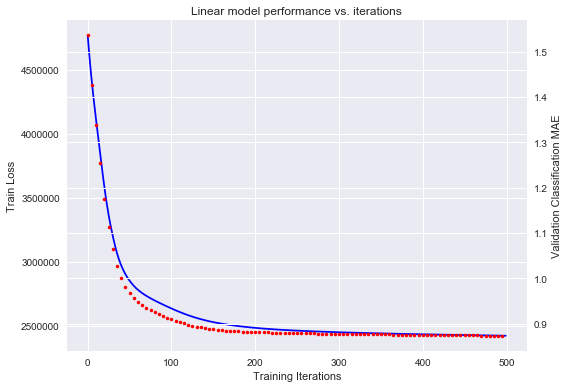

In [25]:
fig, ax1 = plt.subplots()
plt.title('Linear model performance vs. iterations')
ax1.plot(tLoss, 'b-')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Train Loss')

ax2 = ax1.twinx()
ax2.plot(range(0, len(vLoss)*5, 5), vLoss, 'r.')
ax2.set_ylabel('Validation Classification MAE')

fig.tight_layout()

We can see quite clearly that this model does not overfit, just like the linear model. L2 regularization looks to be more than enough. However, we also can see that after about 150 iterations, validation MAE mostly flatlines, which suggests a place for early stopping. 

Let's test the model on our test data now.

In [26]:
test_users = test['user_id']
test_anime = test['anime_id']
test_ratings = test['rating']

In [27]:
indices = test_users.map(lambda x: user_index[x])
bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
gu = indices.map(lambda x: np.zeros(k) if x == -1 else cGu[x])
gu = np.vstack(gu.as_matrix()).astype(np.float)

indices = test_anime.map(lambda x: item_index[x])
bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
gi = indices.map(lambda x: np.zeros(k) if x == -1 else cGi[x])
gi= np.vstack(gi.as_matrix()).astype(np.float)
pi = np.dot(test_ohe_genres, cPi) 


g = np.einsum('ij,ji->i', (gi+pi), np.transpose(gu)) 

preds = bu + bi + g + float(cAlpha)
MAE = 1.0/len(test) * sum(abs(test_ratings-preds))
print ('MAE on test set is: ', float(MAE))

MAE on test set is:  0.8727979383801547


The cool part about adding features to our model is that we can plot them in their latent space and compare them to each other. Our item features are simply genres, and so we can get some understanding of what our model has learned by looking at the latent space.

But if k > 3, it's hard to visualize. This is where our good friend PCA comes in handy.

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(cPi)
print(pca.explained_variance_ratio_) 

[ 0.60410952  0.2424402 ]


So we lose out on about 15% of the variance when tossing the 3rd dimension. That stings a little bit, but it'll have to make do for our visualization.

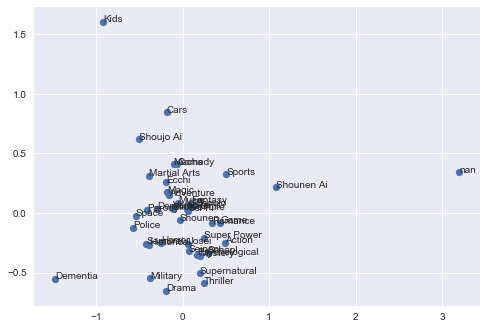

In [40]:
twodim = pca.transform(cPi)
plt.scatter(twodim[:,0], twodim[:,1])
for i, txt in enumerate(all_genres):
    plt.annotate(txt, (twodim[i,0],twodim[i,1]))

What we can see from this plot is that most genres are pretty closely clustered. The obviously noteworthy genres are the outliers: dementia ("mind-twisting plots") is kind of a niche genre choice and kids. Both of these makes sense. There are other exceptions too: cars and sports, as well as shounen ai and shoujo ai (which feature homosexual characters). And finally, there's "nan." This suggests that shows with "NaN" ratings have distinct embeddings in our latent space, as opposed to being simply unlabeled data points. Therefore, fitting them to our existing model (e.g. via EM, which I plan to explore in the next notebook) might be unwise. See the lfm_em notebook for further discussion. 

It'd be cool to get a closer look by removing these outliers.

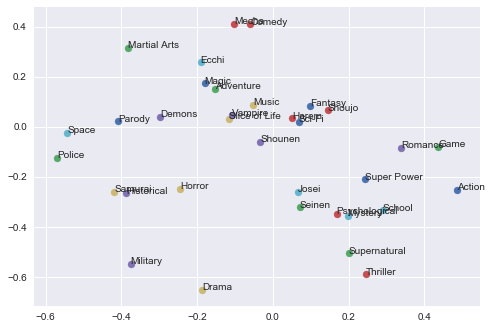

In [46]:
removed = {'Dementia', 'Kids', 'Cars', 'Shoujo Ai', 'nan', 'Shounen Ai', 'Sports'}
for i, txt in enumerate(all_genres):
    if txt in removed: continue
    plt.scatter(twodim[i,0], twodim[i,1])
    plt.annotate(txt, (twodim[i,0],twodim[i,1]))

As a proof of concept, I note that "Samurai" and "Historical" our extremely close together (at about [-0.4, -0.25]), and likewise for "Psychological" and "Mystery" (at about 0.2, -0.35). From here, we can note other very similar genres. "Josei" and "Seinen" are those intended for adult women and adult men, and they are not that far apart. In contrast, "Shoujo" and "Shounen" (intended for teenage women and men) are farther apart. Perhaps when you're old enough, quality matters more than superficial gender differences?

It's also important to note that some are not as clear why they are linked. For example, "Vampire" and "Slice of Life" don't intuitively have much in common, so it is surprising how close they are. 

There are some other interesting insights to draw from this plot. Remember that this is a PCA version of the k-latent space, so not all variance is captured. However, we can nonetheless note that the vertical axis seems to be more whimsical/ non-serious at the top ("Comedy", "Music," "Mecha,"  etc. aren't necessarily grounded narratives), whereas the bottom tend to be more serious ("Drama", "Military," "Thriller"). Meanwhile, it's almost like the horizontal axis is about what kind of tag it is: on the right we have broad categories like "Action," "Romance," and "Game," whereas on the left we have more subject matter: "Space," "Police," "Martial Arts," "Military."  

Remember that this was all discovered via latent factors discovered in our model. So this can give a sense of how the community views things. Look at the first genre plot without the outliers excluded. You'll find that "Shounen Ai" is treated more like a generic category like "Action" and "Romance." You can imagine there are people who strictly watch action shows or romance shows because that interests them, and that's how "Shounen Ai" anime are consumed in the community. In contrast, "Shoujo Ai" tends to be less as an overarching category, suggesting a greater plurality of people might watch them.

In [ ]:
sess.close()